In [1]:
import globals as gl
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PcmPy as pcm
import seaborn as sb

plt.style.use('default')

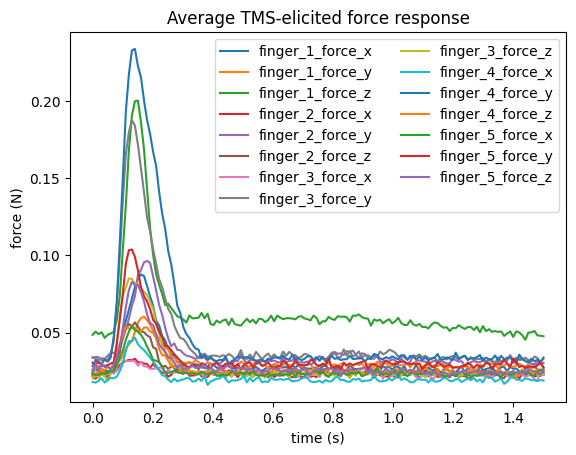

In [40]:
sn = 100
path = os.path.join(gl.baseDir, gl.behavDir, f'p{sn}_testing')
force_resp = np.load(os.path.join(path, 'forceTMS.npy'))
force_resp_avg = force_resp.mean(axis=0).T

tAx = np.linspace(0, force_resp.shape[-1] / gl.sampling_rate, force_resp.shape[-1])

fig, ax = plt.subplots()
ax.plot(tAx, force_resp_avg, label=gl.channels)
ax.legend(ncol=2)
ax.set_xlabel('time (s)')
ax.set_ylabel('force (N)')
ax.set_title('Average TMS-elicited force response')

plt.show()

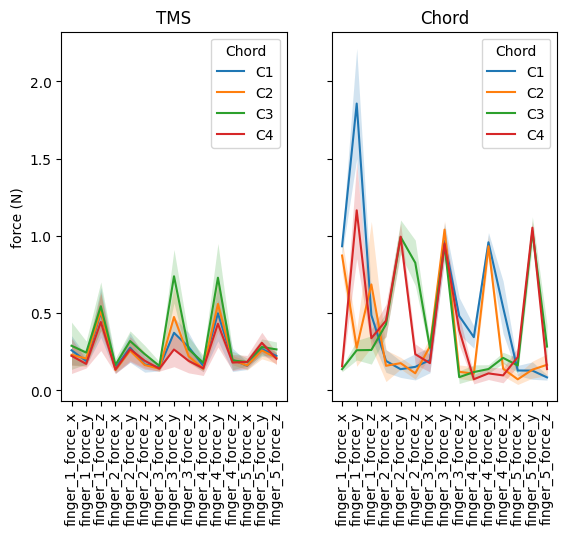

In [44]:
condition = ['TMS', 'Chord']
df = pd.read_csv(os.path.join(path, 'single_trial.tsv'), sep='\t')
#df.Chord = df.Chord.map(gl.chord_mapping)

df_melt = pd.melt(df, value_vars=gl.channels, var_name='channel', id_vars=['condition', 'Chord', 'BN', 'TN'], value_name='force')
df_melt_g = df_melt.groupby(['channel', 'Chord', 'condition', 'BN']).mean(numeric_only=True).reset_index()

fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)

sb.lineplot(data=df_melt_g[df_melt_g['condition']=='TMS'], ax=axs[0], x='channel', y='force', hue='Chord', err_kws={'linewidth': 0}, errorbar='sd')
sb.lineplot(data=df_melt_g[df_melt_g['condition']=='Chord'], ax=axs[1], x='channel', y='force', hue='Chord', err_kws={'linewidth': 0}, errorbar='sd')
for i, ax in enumerate(axs):
    ax.set_xticks(np.arange(len(gl.channels)))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(condition[i])
    ax.set_xlabel('')

axs[0].set_ylabel('force (N)')

plt.show()

TMS, num pos distances: 5 / 6
Chord, num pos distances: 6 / 6


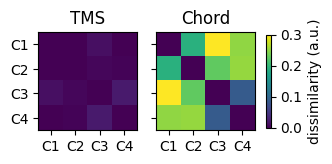

In [58]:
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(3, 2))

for c, cond in enumerate(condition):
    df_tmp = df[df['condition']==cond]
    Y = df_tmp[gl.channels].to_numpy()
    Y_g, cond_vec, part_vec = pcm.group_by_condition(Y, df_tmp.Chord, df_tmp.BN, axis=0)

    # dissimilarity
    G, _ = pcm.est_G_crossval(Y_g, cond_vec, part_vec)
    D = pcm.G_to_dist(G)

    print(f'{cond}, num pos distances: {(D > 0).sum() / 2:.0f} / 6')

    # plot
    ax = axs[c]
    ax.imshow(D, vmin=0, vmax=.3)
    ax.set_xticks(np.arange(4))
    ax.set_yticks(np.arange(4))
    ax.set_xticklabels(list(gl.chord_mapping.keys()))
    ax.set_yticklabels(list(gl.chord_mapping.keys()))
    ax.set_title(cond)

cax = axs[-1].get_images()[0]
cbar = fig.colorbar(cax, ax=axs, orientation='vertical', fraction=.02)
cbar.set_label('dissimilarity (a.u.)')

plt.show()